In [12]:
import os
import nibabel as nib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
import math
from functools import partial

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
! pip install nibabel

In [17]:
case = os.getcwd() + '/drive/MyDrive/masks'

In [18]:
print(case)

/content/drive/MyDrive/masks


In [19]:
os.listdir(case +'/4/')

['4T1GD3D.nii.gz',
 '4FLAIR.nii.gz',
 '4T2.nii.gz',
 '4T1GD3D_MASK.nii.gz',
 '4EDEMA_MASK.nii.gz',
 '4T2_EDEMA_INTENSITY_MASK.nii.gz',
 '4FLAIR_EDEMA_INTENSITY_MASK.nii.gz',
 '4T1GD3D_TUMOR_INTENSITY_MASK.nii.gz',
 '4EDEMA_MASK.dcm']

In [20]:
folder = '4'

In [21]:
glob.glob(case + '/' + folder +'/'+ f'{folder}T1GD3D.nii.gz')



['/content/drive/MyDrive/masks/4/4T1GD3D.nii.gz']

In [23]:
case + '/' + '4' + 'T1GD3D.nii.gz'
case + '/' + '4' + 'T1GD3D.nii.gz'

'/content/drive/MyDrive/masks/4T1GD3D.nii.gz'

In [24]:
t1 = nib.load(case +'/4/' +'4T1GD3D.nii.gz').get_fdata()
t1_mask = nib.load(case +'/4/' +'4T1GD3D_MASK.nii.gz').get_fdata()
t1_mask_inten = nib.load(case +'/4/' +'4T1GD3D_TUMOR_INTENSITY_MASK.nii.gz').get_fdata()
t2 = nib.load(case +'/4/' +'4T2.nii.gz').get_fdata()
t2_edema_inten = nib.load(case +'/4/' +'4T2_EDEMA_INTENSITY_MASK.nii.gz').get_fdata()
flair = nib.load(case +'/4/' +'4FLAIR.nii.gz').get_fdata()
flair_edema_inten= nib.load(case +'/4/' +'4FLAIR_EDEMA_INTENSITY_MASK.nii.gz').get_fdata()
edema_mask = nib.load(case +'/4/' +'4EDEMA_MASK.nii.gz').get_fdata()

In [25]:
t1_mul = t1 * t1_mask

In [26]:
np.concatenate([t1_mask_inten, t2_edema_inten],1).shape

(182, 436, 182)

In [27]:
for i in range(flair.shape[2]):
    plt.figure()
    plt.imshow(flair[:,:,i])

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


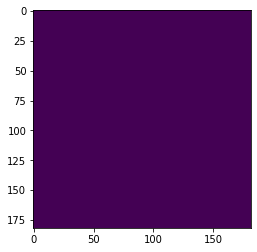

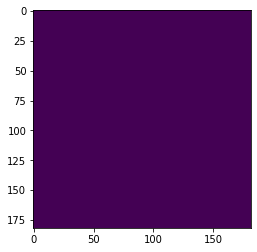

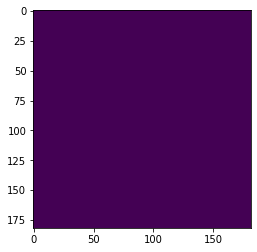

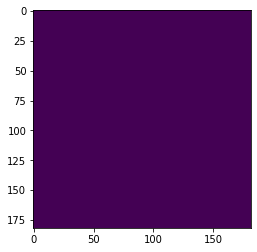

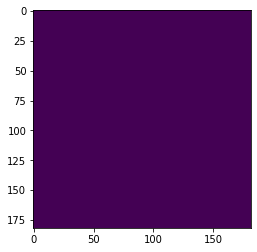

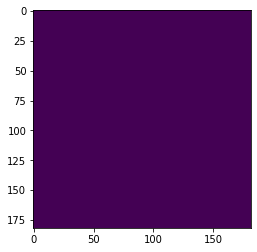

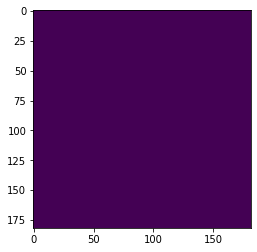

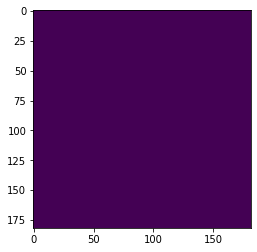

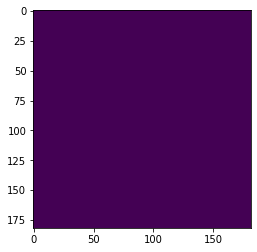

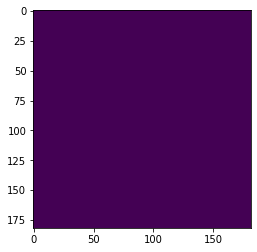

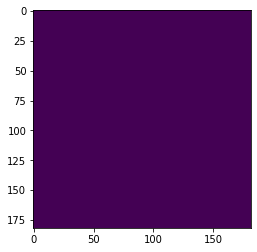

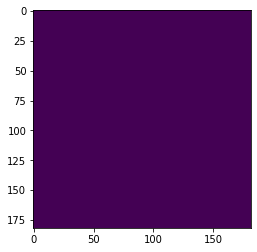

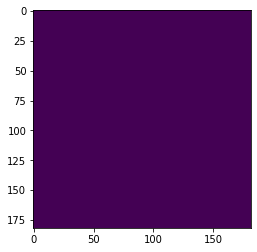

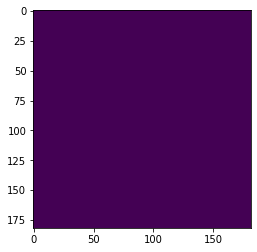

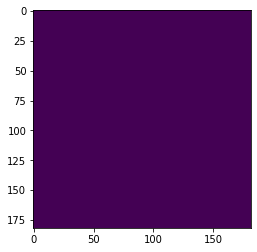

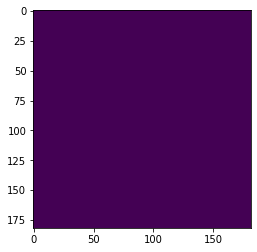

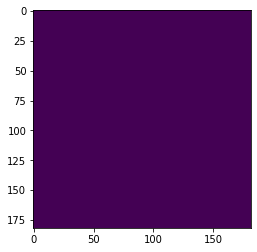

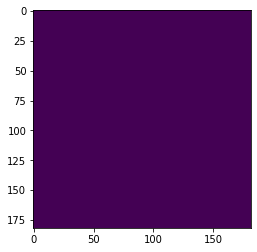

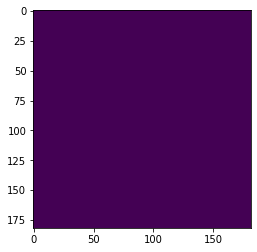

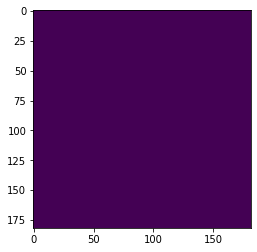

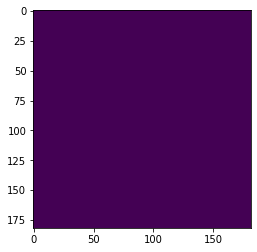

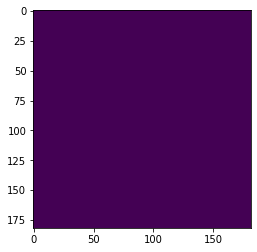

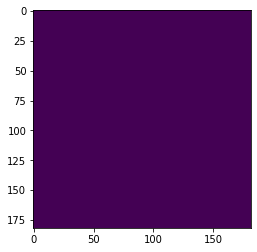

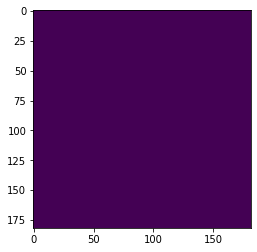

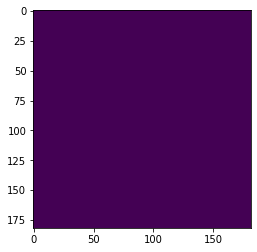

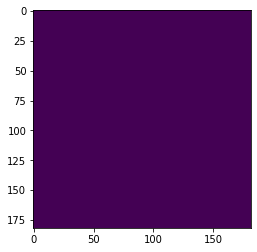

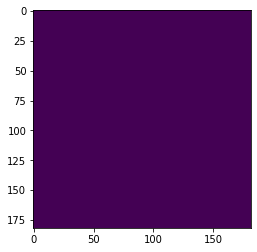

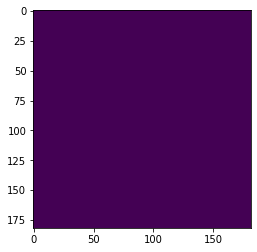

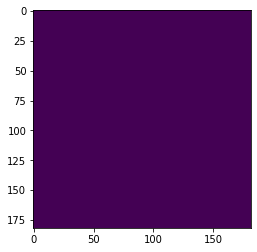

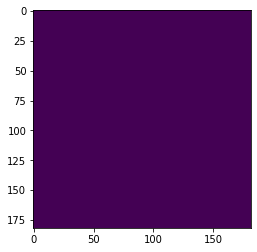

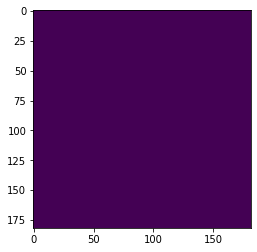

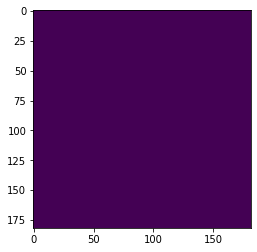

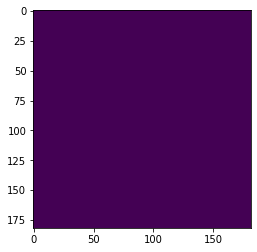

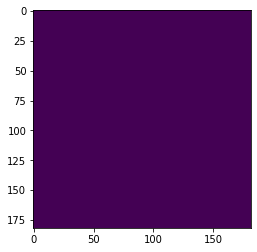

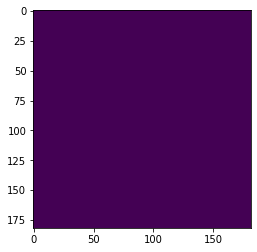

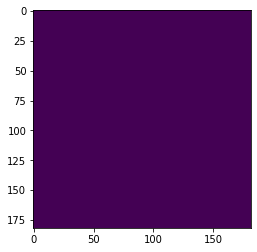

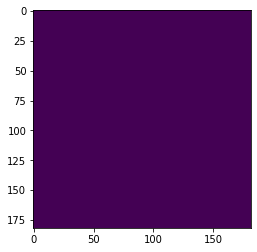

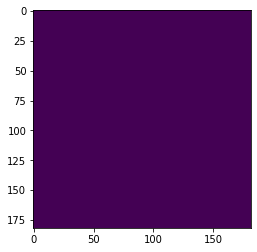

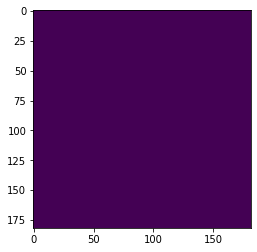

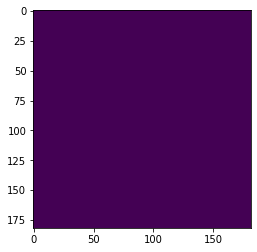

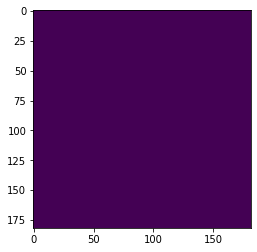

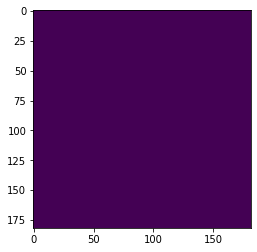

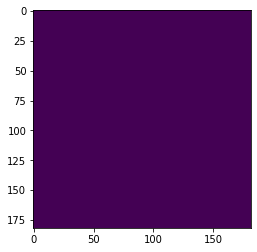

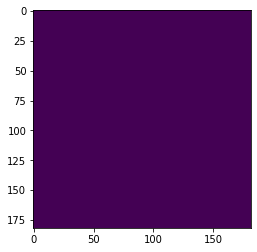

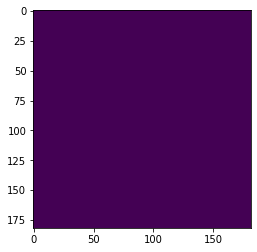

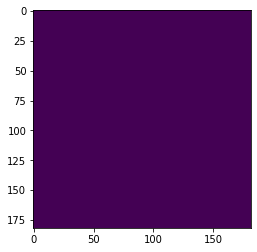

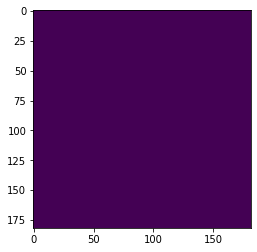

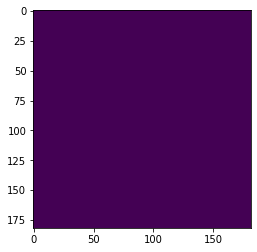

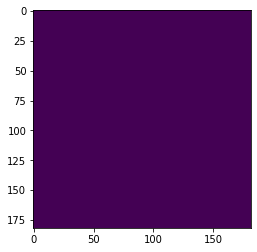

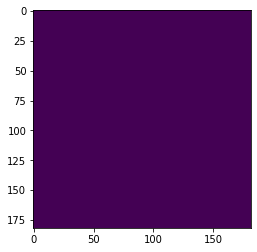

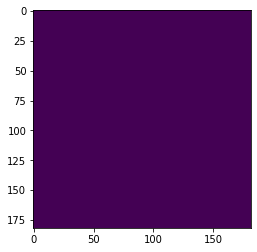

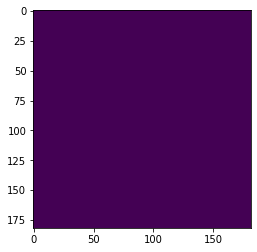

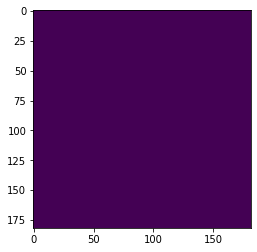

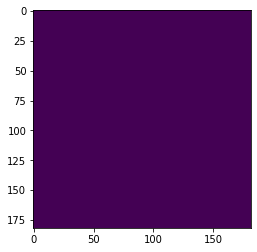

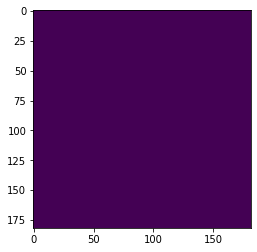

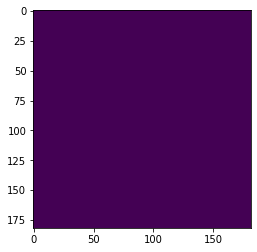

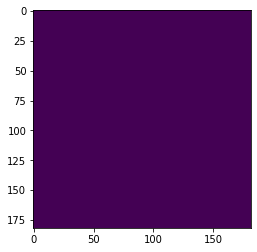

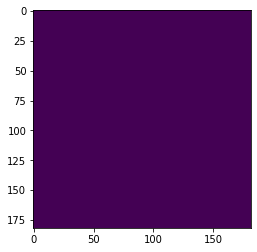

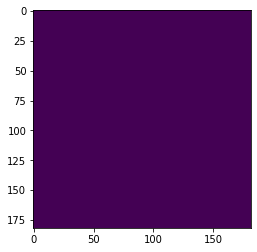

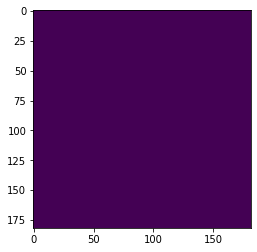

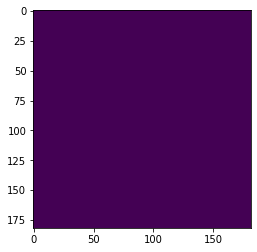

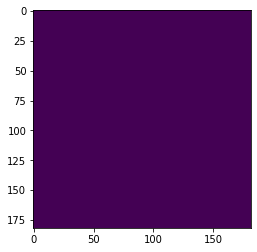

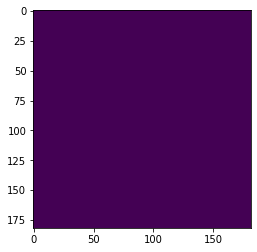

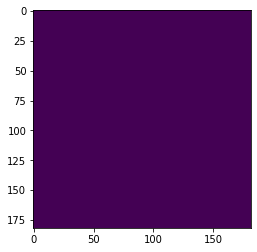

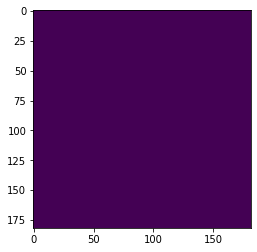

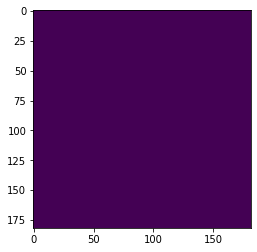

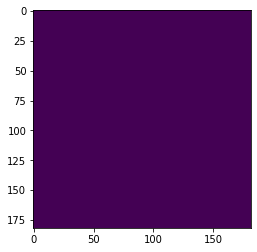

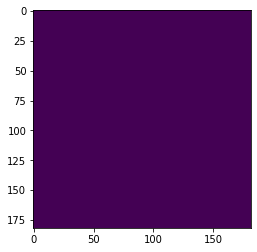

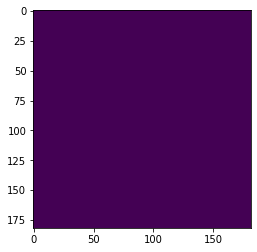

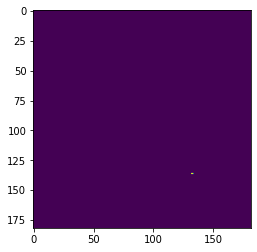

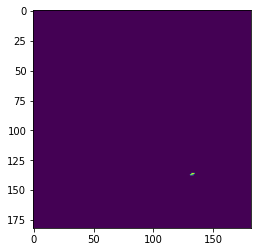

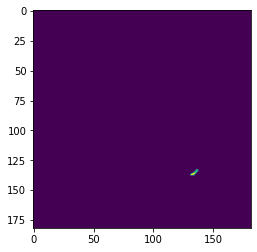

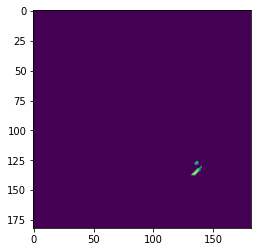

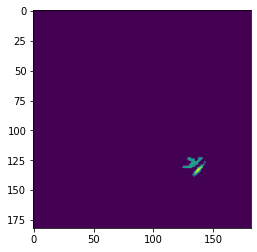

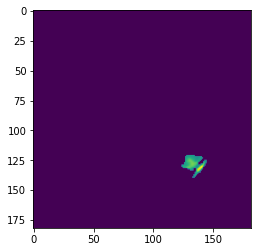

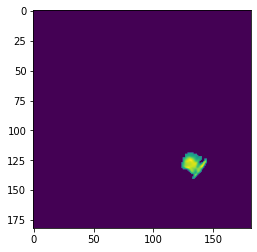

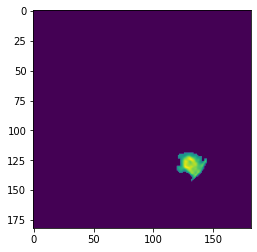

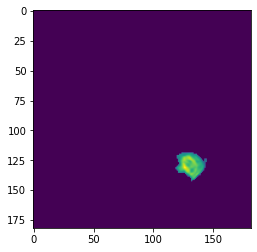

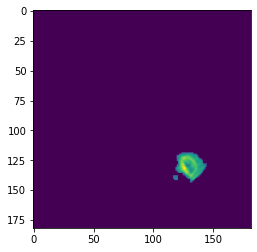

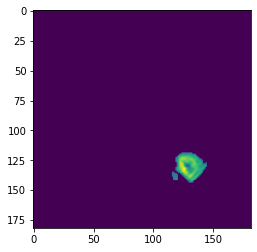

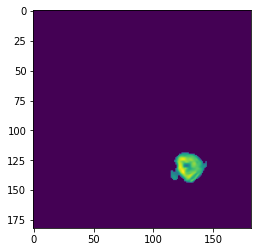

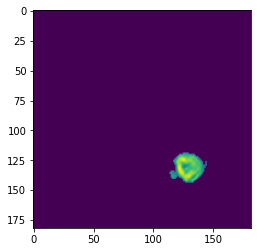

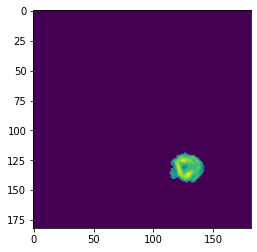

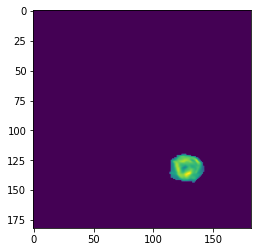

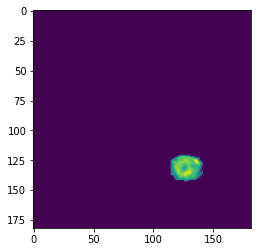

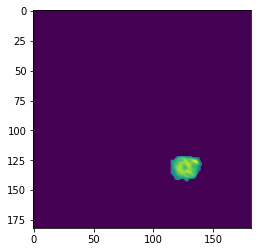

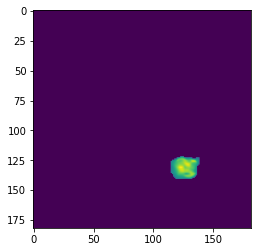

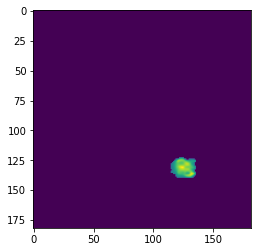

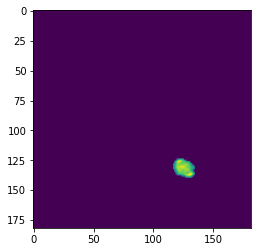

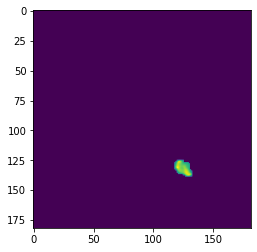

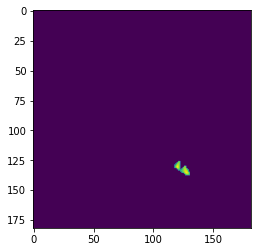

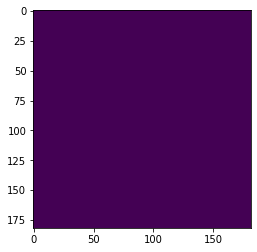

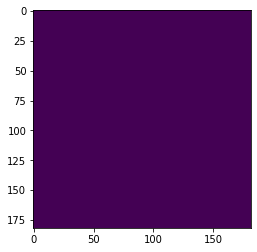

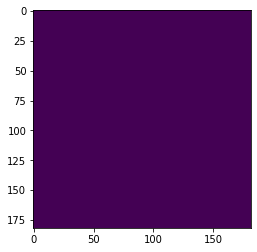

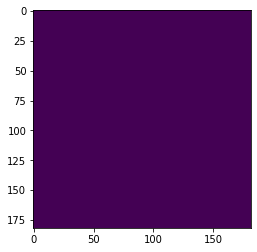

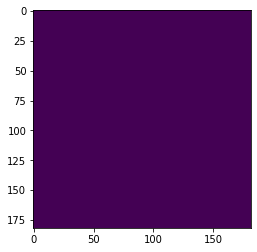

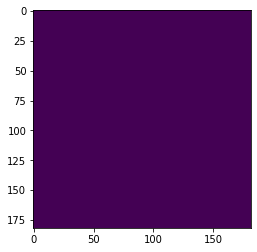

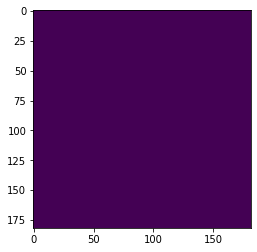

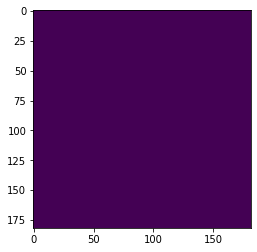

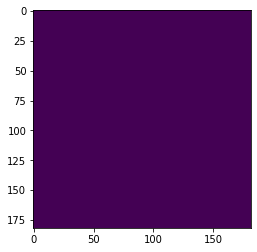

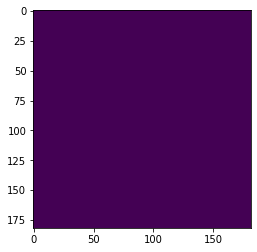

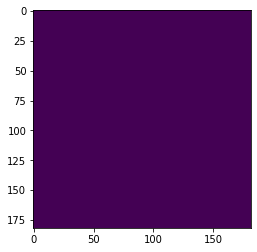

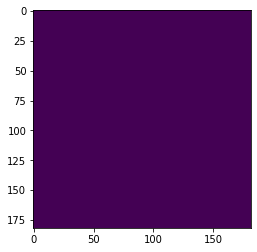

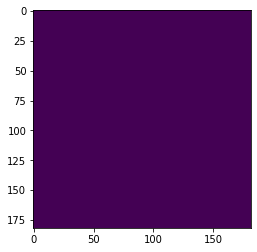

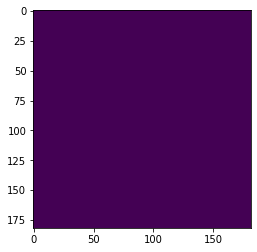

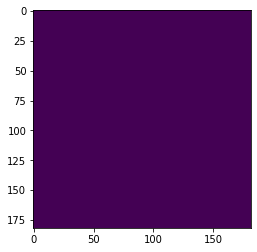

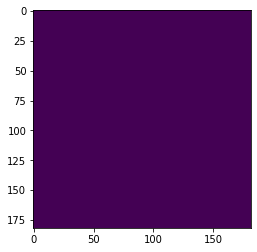

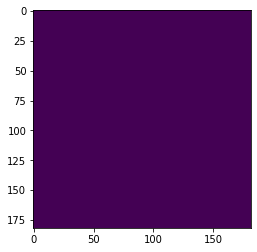

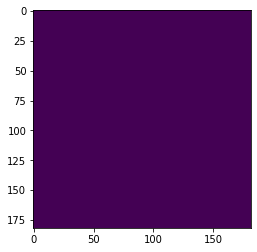

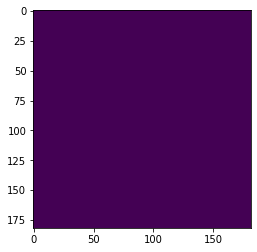

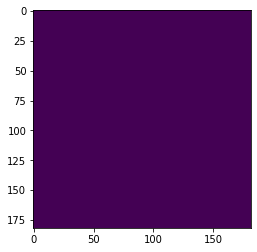

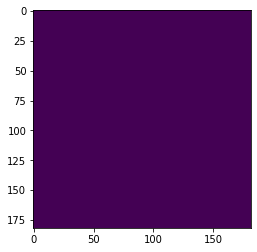

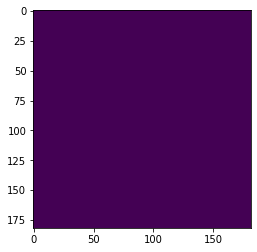

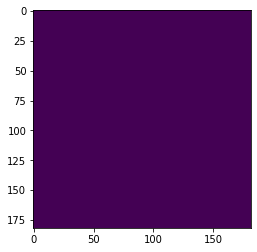

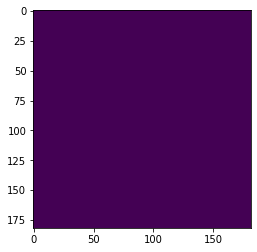

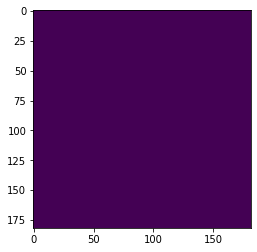

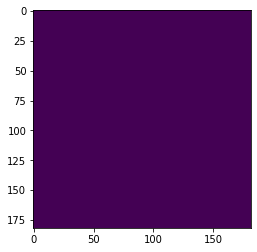

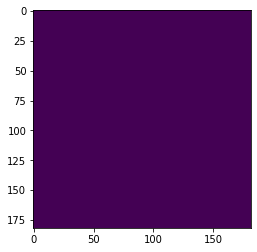

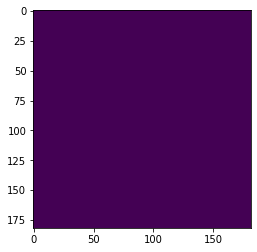

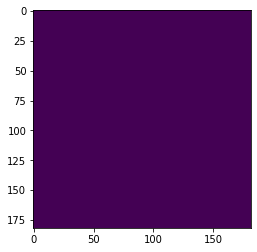

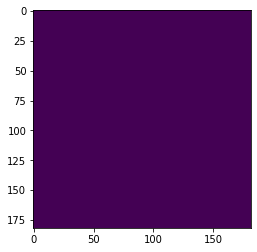

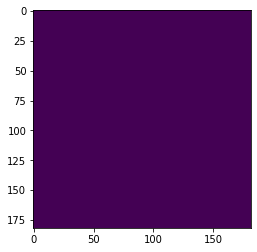

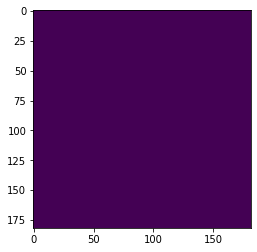

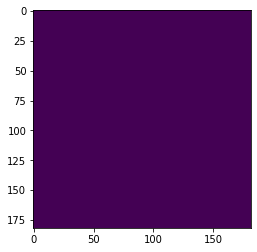

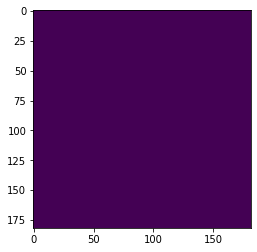

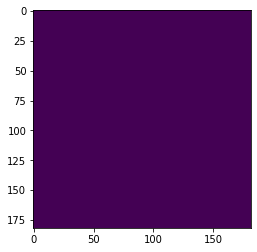

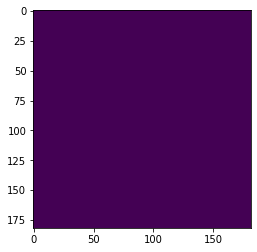

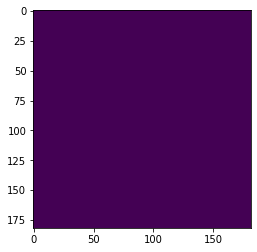

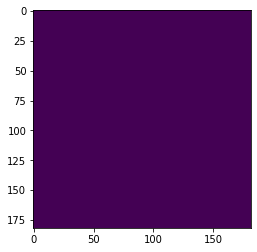

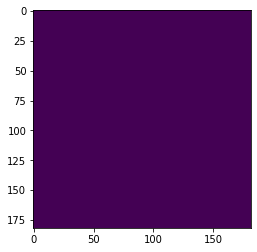

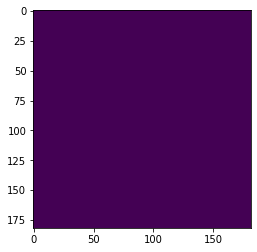

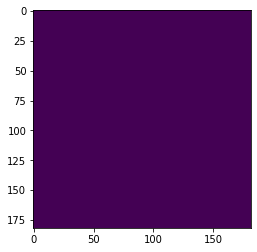

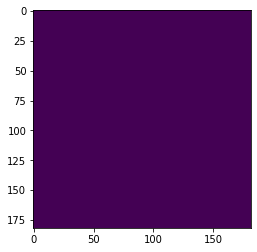

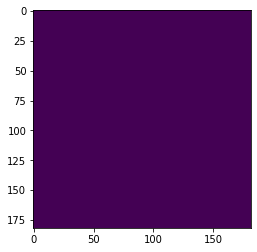

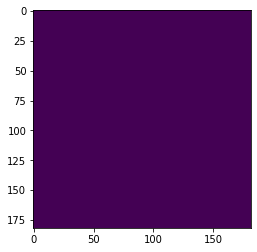

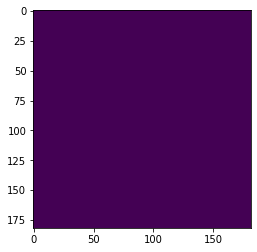

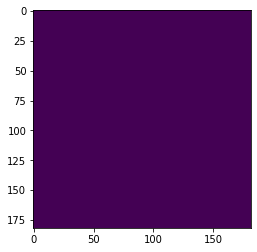

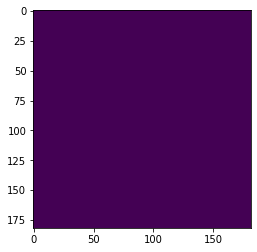

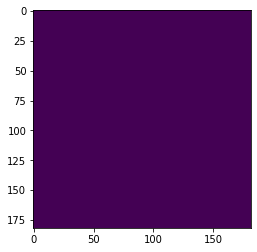

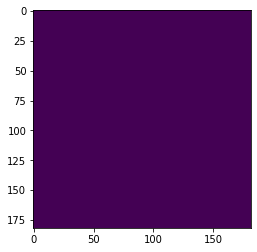

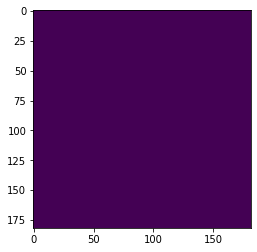

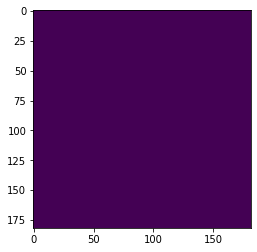

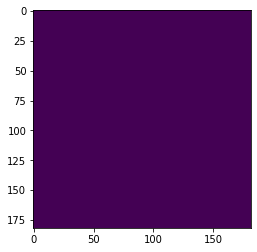

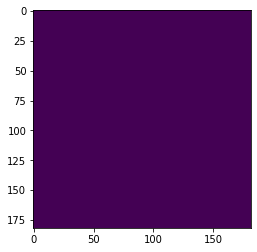

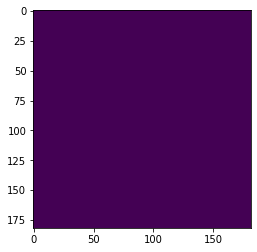

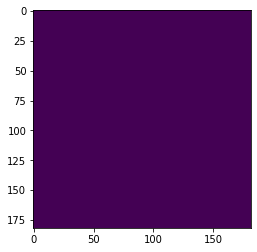

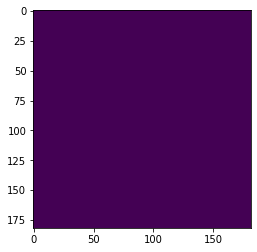

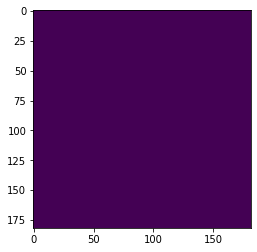

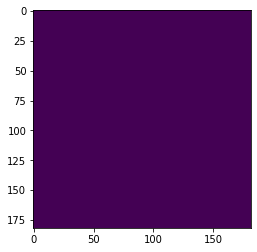

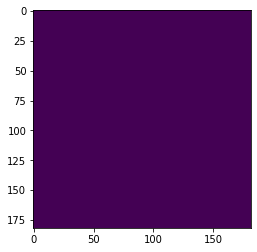

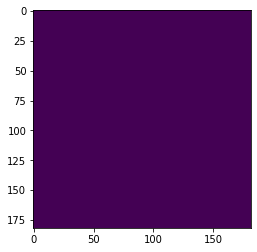

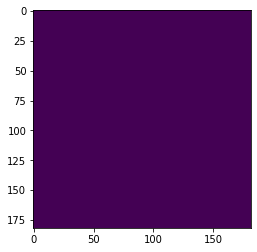

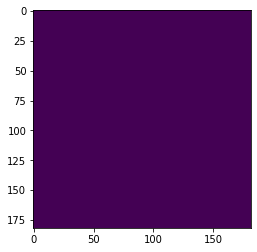

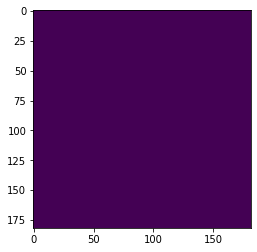

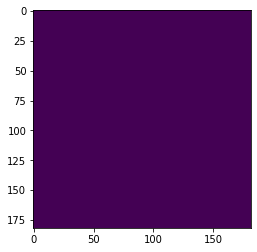

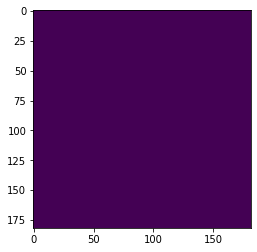

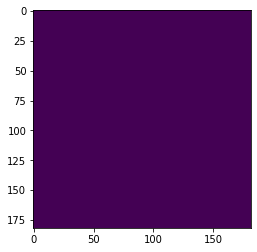

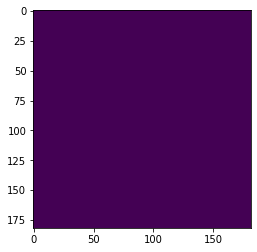

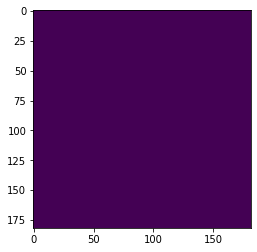

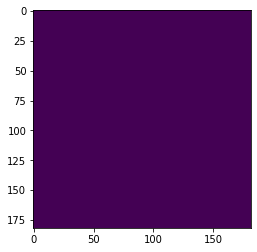

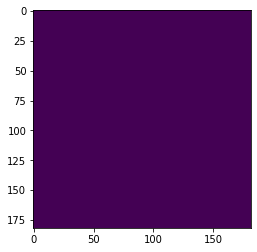

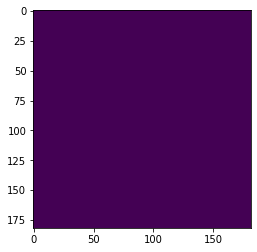

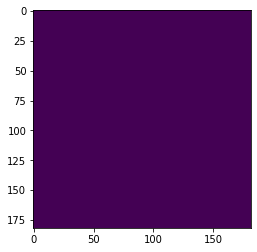

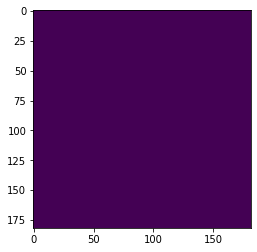

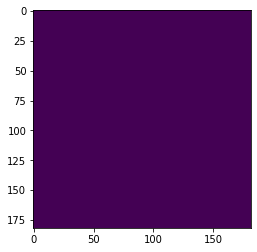

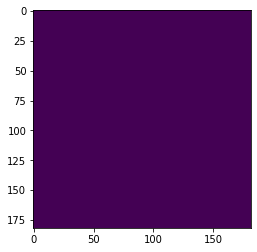

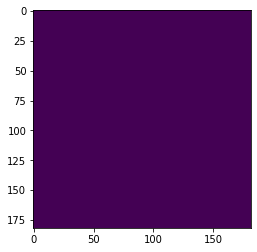

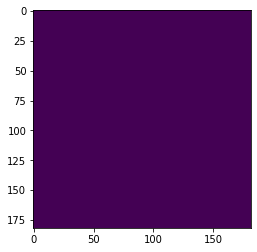

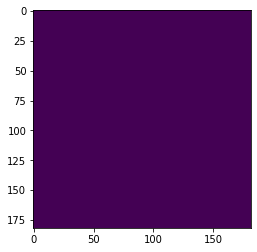

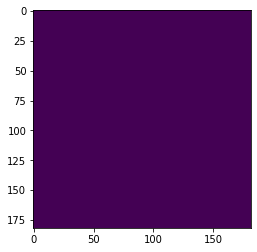

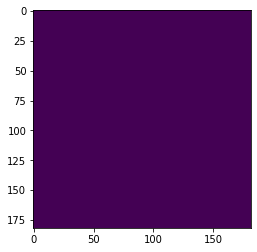

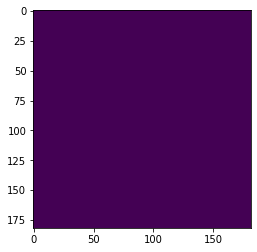

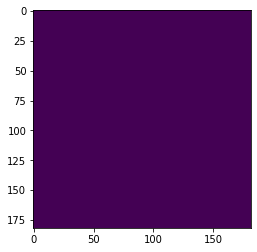

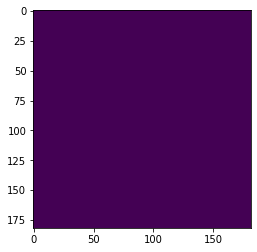

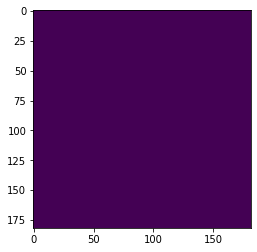

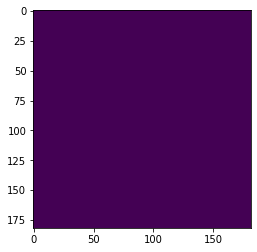

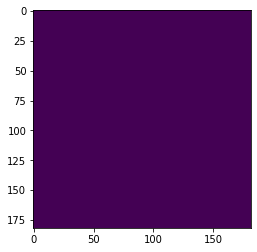

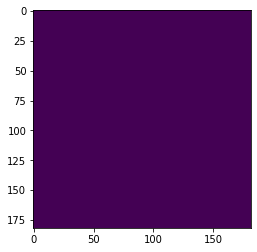

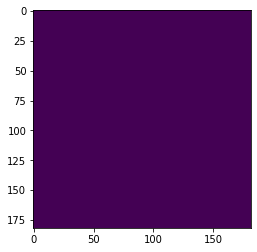

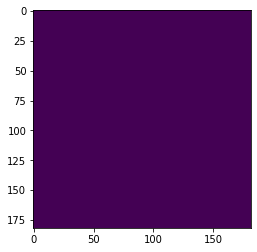

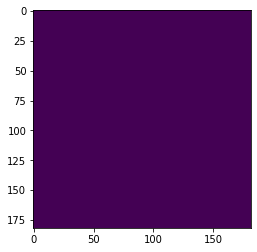

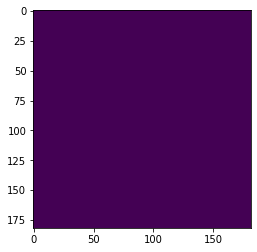

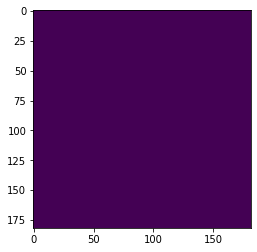

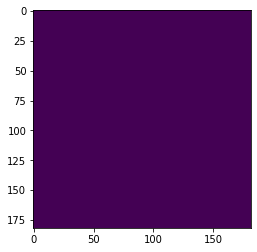

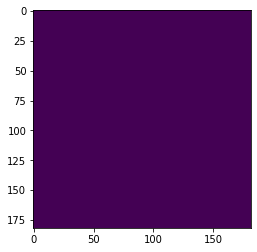

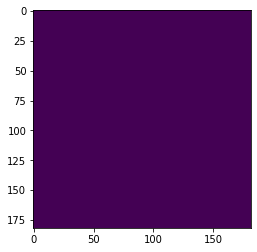

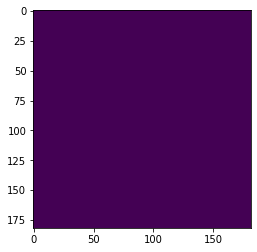

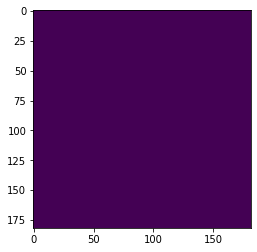

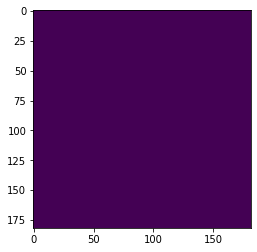

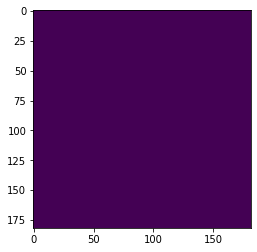

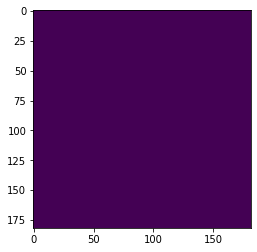

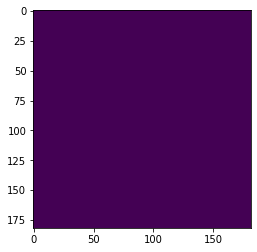

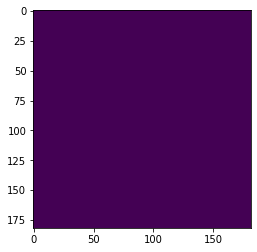

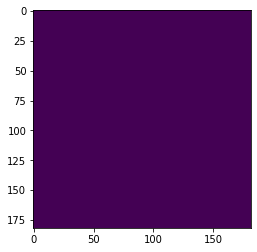

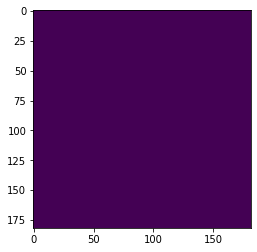

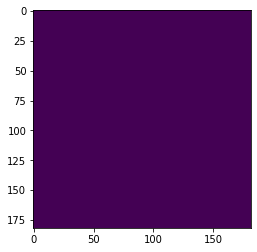

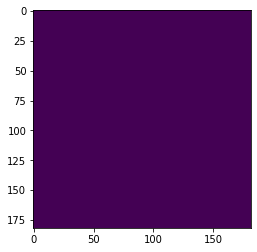

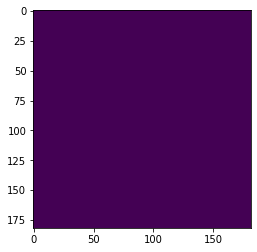

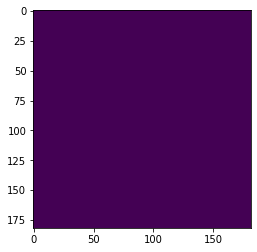

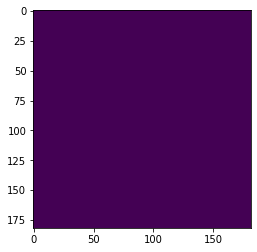

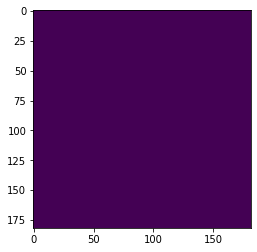

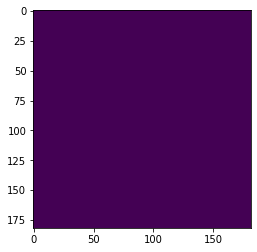

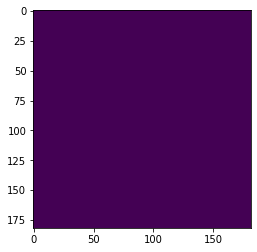

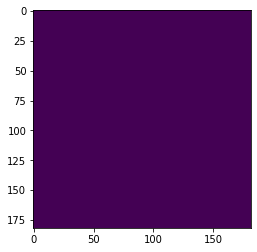

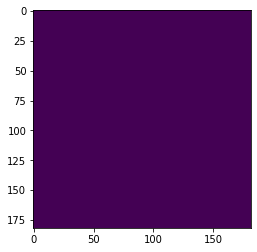

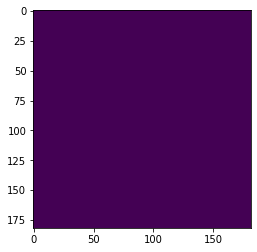

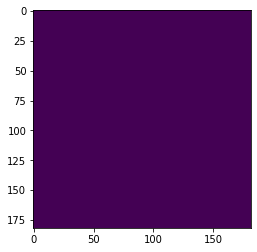

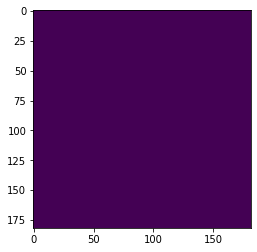

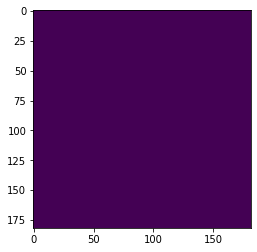

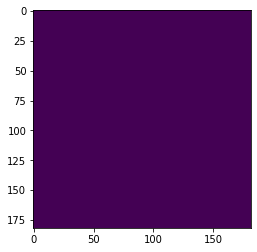

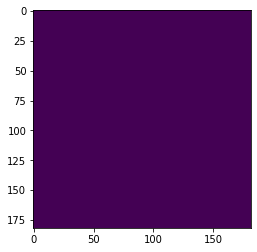

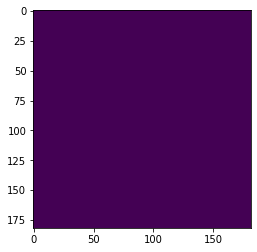

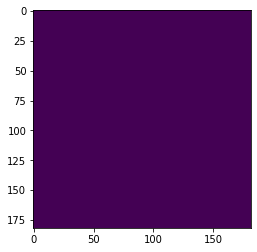

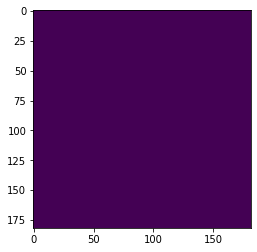

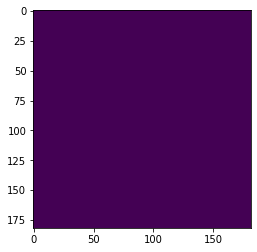

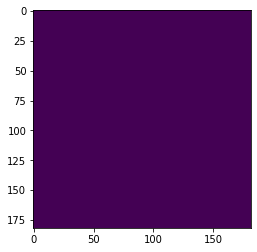

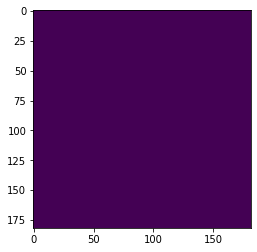

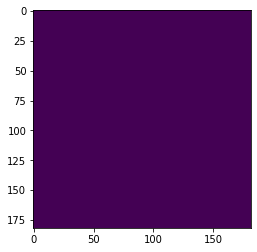

In [28]:
for i in range(t1_mul.shape[1]):
    plt.figure()
    plt.imshow(t1_mask_inten[:,i,:])

In [29]:
for en, i in enumerate(os.walk(case)):
            if en>0:
                gd = glob.glob(i[0] + '/*GD3D.*')
                t2 = glob.glob(i[0] + '/*T2.*')
                flair = glob.glob(i[0] + '/*FLAIR.*')

                edema_mask = glob.glob(i[0] + '/*EDEMA_MA*')

                folder = os.path.basename(i[0])
                print('case number ' + folder + ' max T1GD3D:',nib.load(gd[0]).get_fdata().max())
                print('case number ' + folder + ' max flair:',nib.load(flair[0]).get_fdata().max())

                print('case number ' + folder + ' edmea:',np.unique(nib.load(edema_mask[0]).get_fdata()))

                print('case number ' + folder + ' max T2:',nib.load(t2[0]).get_fdata().max())
                print('case number ' + folder + ' max gd_normal:',normalization(nib.load(gd[0]).get_fdata()).max())

                print('-----------------------------------')

case number 108 max T1GD3D: 636.1326904296875
case number 108 max flair: 780.05078125
case number 108 edmea: [0. 1.]


IndexError: ignored

##  Dataset

In [30]:
dataframe = pd.read_excel(case +'/DATALABLLLLL.xlsx')
le = preprocessing.LabelEncoder()
prim_label = le.fit_transform(dataframe['Primary metastasis site'])

In [31]:
def normalization(image):
    smooth = 1e-9
    mean = np.mean(image, 1, keepdims=True)
    std = np.std(image,1,keepdims=True)
    return (image - mean + smooth)/(std + smooth)

In [32]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, flag = 1):
        super().__init__()
        self.gd = []
        self.flag = flag
        self.t2 = []
        self.flair = []
        self.edema_mask = []
        self.gd_mask = []
        for en, i in enumerate(os.walk(case)):
            if en>0:
                gd = glob.glob(i[0] + '/*GD3D.*')
                t2 = glob.glob(i[0] + '/*T2.*')
                flair = glob.glob(i[0] + '/*FLAIR.*')
                edema_mask = glob.glob(i[0] + '/*EDEMA_MA*')
                gd_mask = glob.glob(i[0] + '/*GD3D_M*')
                
                self.gd.append(gd[0])
                self.gd_mask.append(gd_mask[0])
                self.t2.append(t2[0])
                self.flair.append(flair[0])
                self.edema_mask.append(edema_mask[0])
                
                
                self.flair.sort(key = lambda x : int(x.split('/')[-2]))
                self.edema_mask.sort(key = lambda x : int(x.split('/')[-2]))
                self.t2.sort(key = lambda x : int(x.split('/')[-2]))
                self.gd.sort(key = lambda x : int(x.split('/')[-2]))
                self.gd_mask.sort(key = lambda x : int(x.split('/')[-2]))
    def __len__(self):
        
        return len(self.gd)
        
        
    def __getitem__(self, ind):
        
            
        t1 = nib.load(self.gd[ind]).get_fdata()
        t1_mask = nib.load(self.gd_mask[ind]).get_fdata()
        t1_normal = normalization(t1)
        t1_inten_normal = t1_normal * t1_mask
        
        t2 = nib.load(self.t2[ind]).get_fdata()
        edema_mask = nib.load(self.edema_mask[ind]).get_fdata()
        t2_normal = normalization(t2)
        t2_inten_normal = t2_normal * edema_mask
        
        flair = nib.load(self.flair[ind]).get_fdata()
        flair_normal = normalization(flair)
        flair_inten_normal = flair_normal * edema_mask
        
        if self.flag==1:
            cat = np.transpose(t1_inten_normal, (1,0,2))
            cat = np.expand_dims(cat,0)
            cat = np.float32(cat)
            return {'t1' : cat,'label': prim_label[ind]}
        elif self.flag ==2:
            cat = np.concatenate([t1_inten_normal, flair_inten_normal], 1)
            cat = np.transpose(cat, (1,0,2))
            cat = np.expand_dims(cat,0)
            cat = np.float32(cat)
            return {'t1_flair' : cat,'label': prim_label[ind]}
         
            
        

In [33]:
d = dataset(1)

IndexError: ignored

In [ ]:

dataloader = torch.utils.data.DataLoader(d, batch_size = 1, shuffle = True)

In [ ]:
for i in dat:
    print(i['t1'].shape)

torch.Size([1, 1, 218, 182, 182])
torch.Size([1, 1, 218, 182, 182])
torch.Size([1, 1, 218, 182, 182])
torch.Size([1, 1, 218, 182, 182])
torch.Size([1, 1, 218, 182, 182])
torch.Size([1, 1, 218, 182, 182])


KeyboardInterrupt: 

# resnet3d

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1x1 = nn.Conv3d(in_planes,planes,1,bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv3x3 = nn.Conv3d(planes, planes, 3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv1x1_1 = nn.Conv3d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1x1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv3x3(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv1x1_1(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=1,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=3):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(self._downsample_basic_block,
                                     planes=planes * block.expansion,
                                     stride=stride)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(self.in_planes, planes * block.expansion, 1, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
model = ResNet(Bottleneck, [3, 4, 6, 3], [64, 128, 256, 512], n_classes=6)

In [ ]:
model(i['t1']).shape

torch.Size([1, 2])

In [ ]:
i['t1_flair'].dtype

torch.float64

# Model_resnet2d

In [ ]:
class resnet_block(nn.Module):
    expansion = 4
    
    def __init__(self, input_activation, intermediate, stride = 1):
        super().__init__()
        output = intermediate * self.__class__.expansion

        self.conv1x1_1 = nn.Conv2d(input_activation, intermediate, 1)
        self.BN1 = nn.BatchNorm2d(intermediate)
        
        self.conv3x3 =  nn.Conv2d(intermediate, intermediate, 3, stride=stride, padding=1)
        self.BN2 = nn.BatchNorm2d(intermediate)

        self.conv1x1_2 =  nn.Conv2d(intermediate, output, 1)
        self.BN3 = nn.BatchNorm2d(output)
        
        self.down = None
        if ( input_activation != output ) or ( stride > 1 ) :
            
            self.down = nn.Sequential(
                                      nn.Conv2d(input_activation, output, 1, stride=stride),
                                      nn.BatchNorm2d(output)
                                      )
        
    def forward(self , inp):
        inp1 = inp
        c = F.relu(self.BN1(self.conv1x1_1(inp)))
        c = F.relu(self.BN2(self.conv3x3(c)))
        c = self.BN3(self.conv1x1_2(c))
        if self.down is not None:
            inp1 = self.down(inp)
        out = F.relu(c + inp1) 
        
        return out    
    

In [ ]:
class resnet_2d(nn.Module):
  

    def __init__(self, layers, width=64, num_class):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # residual layers
        self._inplanes = width  # this is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        embed_dim = width * 32  # the ResNet feature dimension
        self.linear = nn.Linear(,num_class)
        self.out = nn.Linear()
    def _make_layer(self, planes, blocks, stride=1):
        layers = [resnet_block(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(resnet_block(self._inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        batch = x.shape[0]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x_view = x.view(batch, -1)
        x = self.linear(x_view)
        return x


In [ ]:
m = resnet_2d([3,4,6,3])

In [ ]:
x = torch.rand(1,3,200,200)

In [ ]:
m(x).shape

# Train

In [ ]:
device = torch.device("cuda:0" if  torch.cuda.is_available() else "cpu")

In [ ]:
epochs = 4
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(epochs):
    hist_loss_per_batch = []
    for batch, data in enumerate(dataloader, 1): 
            image = data['t1']
            segment = data['label']
            segment_hat = model(image)
            loss = F.cross_entropy(segment_hat, segment) 
            hist_loss_per_batch.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    mean_loss = sum(hist_loss_per_batch)/batch
    print(f'Loss in epoch{epoch} is :', mean_loss)
        
        

Loss in epoch0 is : 2.392040048660779
Loss in epoch1 is : 1.5276699589435445
Loss in epoch2 is : 1.4415517239723095


KeyboardInterrupt: 

In [ ]:

def train_step(model, dataload_train, dataload_validation 
               epochs = 100,
               lr = 0.001,
              best = 0.86,
              grad_clip = None):

    epochs = epochs
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        hist_loss_per_batch = []
        for batch, data in enumerate(dataload_train, 1): # dataload return a dict {'image': tensor, 'seg': tensor}
            image = data['image'].to(device)
            segment = data['label'].to(device)
            segment_hat = model(image)
            loss = F.cross_entropy(segment_hat, segment) 
            hist_loss_per_batch.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        mean_loss = sum(hist_loss_per_batch)/batch
        print(f'Loss in epoch{epoch} is :', mean_loss)
        
        
        for batch_val, data_val in enumerate(dataload_validation, 1):
            imaget = data_val['image'].to(device)
            segment_t = data_val['seg'].to(device)

            with torch.set_grad_enabled(False):
                segment_hat_t = model(imaget)
                val_loss = Loss(segment_hat_t,segment_t)
                
       
      
        if mean_dice_val > best:
            torch.save({ "epoch" : epoch, 
                         "model_state" : model.state_dict(),
                         "optimizer" : optimizer.state_dict(),
                         "hist_loss" : hist_loss_per_epoch,
                         "hist_val" : hist_val_per_epoch
                       },

                       f"model_{model.__class__.__name__}_epoch_{epoch}_loss_{Loss.__name__}.pt")

        
    return hist_loss_per_epoch, hist_val_per_epoch



                